<a href="https://colab.research.google.com/github/turnleftorgo/Deep_learning/blob/main/CNN_CIFAR_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Name: Lexi Li
- Student ID: 34217886

# Load dataset

CIFAR-100 dataset consists of 100 classes with a total of 60,000 images, where 50,000 images are used for training and 10,000 images are used for testing.

In [ ]:
import torch
from torchvision import datasets, transforms

In [ ]:
batch_size = 64

trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples:   {len(trainset)}")
print(f"Test samples:       {len(testset)}")


100%|██████████| 169M/169M [00:13<00:00, 12.9MB/s]


Training samples:   50000
Test samples:       10000


In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os

class_names = trainset.classes

def imshow(img):
    img = img*255  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)).astype("uint8"))  # convert from Tensor image

def visualize_data(images, categories, images_per_row = 8):

    n_images = len(images)
    n_rows = math.ceil(float(n_images)/images_per_row)
    fig = plt.figure(figsize=(1.5*images_per_row, 1.5*n_rows))
    fig.patch.set_facecolor('white')
    for i in range(n_images):
        plt.subplot(n_rows, images_per_row, i+1)
        plt.xticks([])
        plt.yticks([])
        imshow(images[i])
        class_index = categories[i].item()
        plt.xlabel(class_names[class_index])
    plt.show()

In [ ]:
# obtain one batch of training images
data_iter = iter(trainloader)
images, labels = next(data_iter)
images = images.numpy() # convert images to numpy for display

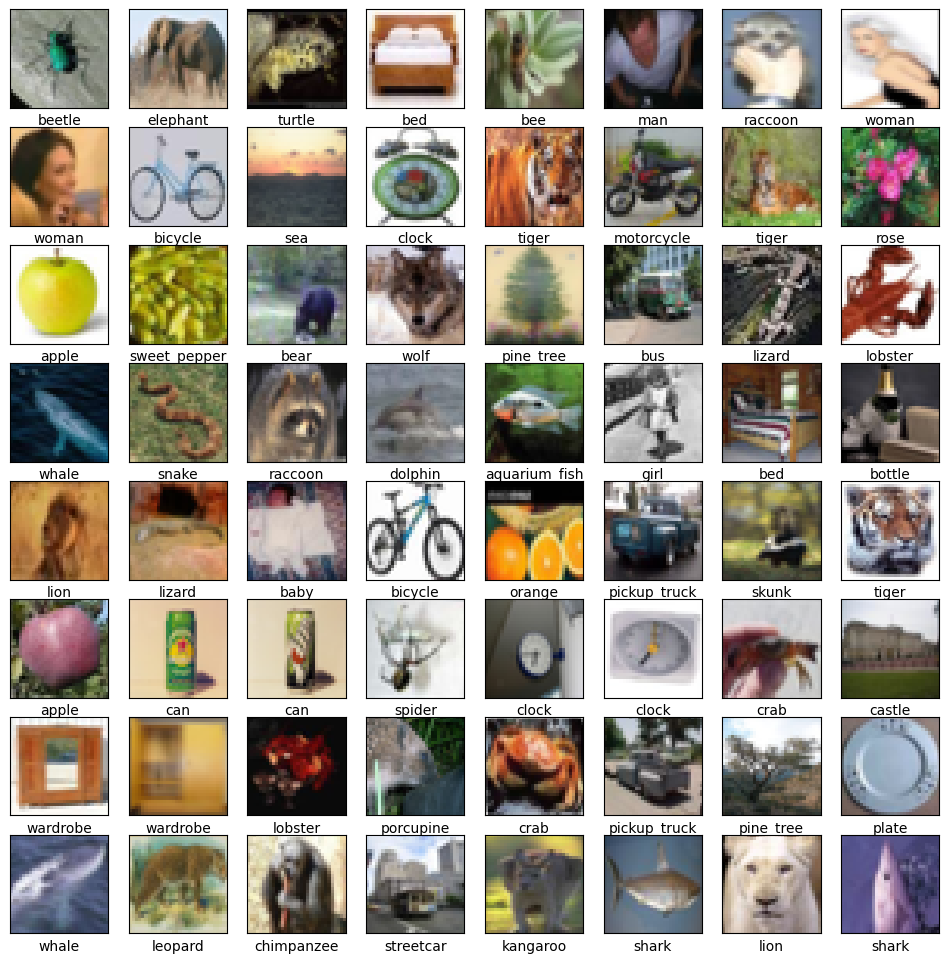

In [ ]:
visualize_data(images, labels)

#Task 1 - Baseline CNN model (4 marks)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class basic_model(nn.Module):

      def __init__ (self):
          super().__init__()
          self.conv1 = nn.Conv2d(3, 16, kernel_size=7, stride=1, padding=0)
          self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
          self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
          self.fc1 = nn.Linear(6*6*32,128)
          self.fc2 = nn.Linear(128,100)




      def forward(self, x):
          x = F.relu(self.conv1(x))
          x = self.pool(x)
          x = F.relu(self.conv2(x))
          x = self.pool(x)
          x = x.view(-1, 6*6*32)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)

          return x


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
basic_model = basic_model().to(device)


learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(basic_model.parameters(), lr=learning_rate)

total = 0
for name, param in basic_model.named_parameters():
    if param.requires_grad:          # skip frozen layers if any
        n_param = param.numel()
        print(f"{name:30s}  shape={tuple(param.shape)!s:15}  n={n_param:>8,d}")
        total += n_param

print(f"\nTOTAL TRAINABLE PARAMETERS: {total:,}")


conv1.weight                    shape=(16, 3, 7, 7)    n=   2,352
conv1.bias                      shape=(16,)            n=      16
conv2.weight                    shape=(32, 16, 5, 5)   n=  12,800
conv2.bias                      shape=(32,)            n=      32
fc1.weight                      shape=(128, 1152)      n= 147,456
fc1.bias                        shape=(128,)           n=     128
fc2.weight                      shape=(100, 128)       n=  12,800
fc2.bias                        shape=(100,)           n=     100

TOTAL TRAINABLE PARAMETERS: 175,684


In [ ]:
def compute_loss(model, loss_fn, loader):
  loss = 0
  model.eval()

  with torch.no_grad():

    for (batchX, batchY) in loader:

      batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device).type(torch.long)
      loss += loss_fn(model(batchX), batchY)

  model.train()

  return float(loss)/len(loader)

In [ ]:
def compute_acc(model, loader):
    correct = 0
    totals = 0

    model.eval()
    for (batchX, batchY) in loader:

        batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device)
        outputs = model(batchX)
        totals += batchY.size(0)  #
        predicted = torch.argmax(outputs.data, 1)
        correct += (predicted == batchY).sum().item()

    return correct / totals

In [ ]:
def fit(model= None, train_loader = None, valid_loader= None, optimizer = None,patience=3,
        num_epochs = 50, verbose = True, seed= 1234):
  torch.manual_seed(seed)



  model.to(device)
  optim = optimizer
  history = dict()

  history['val_loss'] = list()
  history['val_acc'] = list()
  history['train_loss'] = list()
  history['train_acc'] = list()

  for epoch in range(num_epochs):
    model.train()
    for (X, y) in train_loader:

      X,y = X.to(device), y.to(device)

      outputs = model(X.type(torch.float32))
      loss = loss_fn(outputs, y.type(torch.long))
      # Backward and optimize
      optim.zero_grad()
      loss.backward()
      optim.step()

    #losses and accuracies for epoch
    val_loss = compute_loss(model, loss_fn, valid_loader)
    val_acc = compute_acc(model, valid_loader)
    train_loss = compute_loss(model, loss_fn, train_loader)
    train_acc = compute_acc(model, train_loader)

    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)



    if not verbose:
      print(f"Epoch {epoch+1}/{num_epochs}")
      print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")

  return history

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    """
    history: dict with keys
      'train_loss', 'val_loss', 'train_acc', 'val_acc'
      each a list of length num_epochs
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'],   label='Val Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'],   label='Val Acc')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
history = fit(model= basic_model, train_loader=trainloader, valid_loader = testloader, optimizer = optimizer, num_epochs= 30, verbose = False)

Epoch 1/30
train loss= 3.6035 - train acc= 15.09% - valid loss= 3.6492 - valid acc= 14.47%
Epoch 2/30
train loss= 3.2283 - train acc= 21.80% - valid loss= 3.3068 - valid acc= 20.61%
Epoch 3/30
train loss= 3.0519 - train acc= 25.67% - valid loss= 3.1623 - valid acc= 24.14%
Epoch 4/30
train loss= 2.8890 - train acc= 28.83% - valid loss= 3.0445 - valid acc= 26.00%
Epoch 5/30
train loss= 2.7516 - train acc= 31.51% - valid loss= 2.9385 - valid acc= 27.90%
Epoch 6/30
train loss= 2.6792 - train acc= 32.81% - valid loss= 2.9218 - valid acc= 29.25%
Epoch 7/30
train loss= 2.5836 - train acc= 34.97% - valid loss= 2.8550 - valid acc= 30.27%
Epoch 8/30
train loss= 2.5656 - train acc= 35.11% - valid loss= 2.8706 - valid acc= 30.18%
Epoch 9/30
train loss= 2.4857 - train acc= 36.73% - valid loss= 2.8189 - valid acc= 30.67%
Epoch 10/30
train loss= 2.4432 - train acc= 37.71% - valid loss= 2.8034 - valid acc= 31.15%
Epoch 11/30
train loss= 2.3859 - train acc= 38.70% - valid loss= 2.7900 - valid acc= 32.0

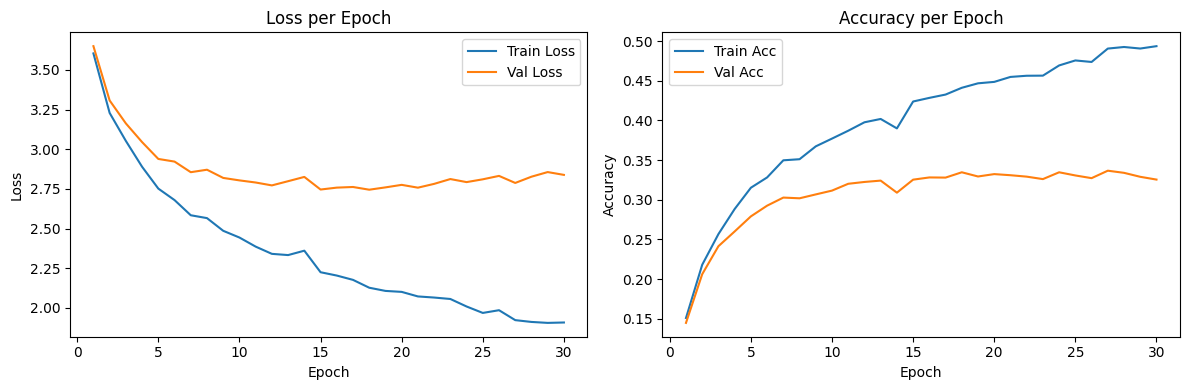

In [ ]:
plot_history(history)

## best accuracy: 33.66%

#Task 2 - Improve the baseline model (7 marks)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [ ]:
batch_size = 64

trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples:   {len(trainset)}")
print(f"Test samples:       {len(testset)}")


Training samples:   50000
Test samples:       10000


In [ ]:
def compute_loss(model, loss_fn, loader):
  loss = 0
  model.eval()

  with torch.no_grad():

    for (batchX, batchY) in loader:

      batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device).type(torch.long)
      loss += loss_fn(model(batchX), batchY)

  model.train()

  return float(loss)/len(loader)

In [ ]:
def compute_acc(model, loader):
    correct = 0
    totals = 0

    model.eval()
    for (batchX, batchY) in loader:

        batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device)
        outputs = model(batchX)
        totals += batchY.size(0)  #
        predicted = torch.argmax(outputs.data, 1)
        correct += (predicted == batchY).sum().item()

    return correct / totals

In [ ]:
def fit(model= None, train_loader = None, valid_loader= None, optimizer = None,
        num_epochs = 50, verbose = True, seed= 1234):
  torch.manual_seed(seed)

  model.to(device)
  optim = optimizer
  history = dict()

  history['val_loss'] = list()
  history['val_acc'] = list()
  history['train_loss'] = list()
  history['train_acc'] = list()

  for epoch in range(num_epochs):
    model.train()
    for (X, y) in train_loader:

      X,y = X.to(device), y.to(device)

      outputs = model(X.type(torch.float32))
      loss = loss_fn(outputs, y.type(torch.long))
      # Backward and optimize
      optim.zero_grad()
      loss.backward()
      optim.step()

    #losses and accuracies for epoch
    val_loss = compute_loss(model, loss_fn, valid_loader)
    val_acc = compute_acc(model, valid_loader)
    train_loss = compute_loss(model, loss_fn, train_loader)
    train_acc = compute_acc(model, train_loader)

    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    if not verbose:
      print(f"Epoch {epoch+1}/{num_epochs}")
      print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")

  return history

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    """
    history: dict with keys
      'train_loss', 'val_loss', 'train_acc', 'val_acc'
      each a list of length num_epochs
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'],   label='Val Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'],   label='Val Acc')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


## Data Augmentation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class basic_model(nn.Module):

      def __init__ (self):
          super().__init__()
          self.conv1 = nn.Conv2d(3, 16, kernel_size=7, stride=1, padding=0)
          self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
          self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
          self.fc1 = nn.Linear(6*6*32,128)
          self.fc2 = nn.Linear(128,100)




      def forward(self, x):
          x = F.relu(self.conv1(x))
          x = self.pool(x)
          x = F.relu(self.conv2(x))
          x = self.pool(x)
          x = x.view(-1, 6*6*32)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)

          return x



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = basic_model().to(device)

learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split




batch_size  = 64
test_split   = 0.1
img_height, img_width = 32, 32


train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),                                           # 50% probability, flips the image left & right
    transforms.RandomRotation(15),                                               # sample a routation angle uniformly in -15 degree to 15 degree ,
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),

])






trainset_da = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transforms)
trainloader_da = torch.utils.data.DataLoader(trainset_da, batch_size=batch_size, shuffle=True, num_workers=2)











Epoch 1/30
train loss= 3.7697 - train acc= 11.93% - valid loss= 3.7384 - valid acc= 12.55%
Epoch 2/30
train loss= 3.4303 - train acc= 17.67% - valid loss= 3.3669 - valid acc= 19.28%
Epoch 3/30
train loss= 3.2995 - train acc= 20.24% - valid loss= 3.2420 - valid acc= 21.81%
Epoch 4/30
train loss= 3.1913 - train acc= 22.37% - valid loss= 3.1368 - valid acc= 23.74%
Epoch 5/30
train loss= 3.0898 - train acc= 24.10% - valid loss= 3.0288 - valid acc= 25.33%
Epoch 6/30
train loss= 3.0418 - train acc= 24.85% - valid loss= 2.9962 - valid acc= 26.57%
Epoch 7/30
train loss= 3.0226 - train acc= 25.56% - valid loss= 2.9670 - valid acc= 27.23%
Epoch 8/30
train loss= 2.9347 - train acc= 27.18% - valid loss= 2.8836 - valid acc= 28.27%
Epoch 9/30
train loss= 2.9111 - train acc= 27.83% - valid loss= 2.8577 - valid acc= 29.16%
Epoch 10/30
train loss= 2.8810 - train acc= 28.06% - valid loss= 2.8209 - valid acc= 29.94%
Epoch 11/30
train loss= 2.8979 - train acc= 27.71% - valid loss= 2.8406 - valid acc= 29.3

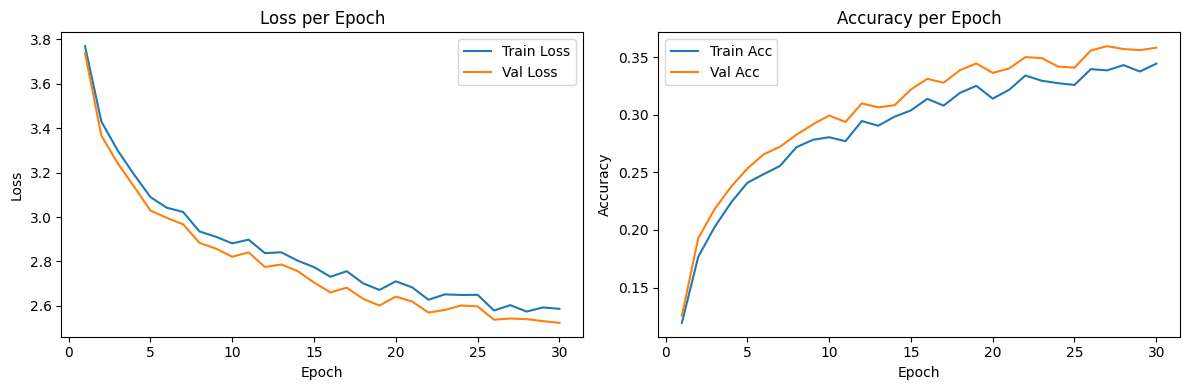

In [ ]:
history = fit(model= model , train_loader=trainloader_da, valid_loader = testloader, optimizer = optimizer, num_epochs= 30, verbose = False)
plot_history(history)

## dropout & normalization

In [ ]:
import torch
import torch.nn as nn

model1 = nn.Sequential(

    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=7, stride=1, padding=0),
    nn.BatchNorm2d(16),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(6 * 6 * 32, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(128, 100)
)



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model1.to(device)

learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
history = fit(model= model, train_loader=trainloader, valid_loader = testloader, optimizer = optimizer, num_epochs= 20, verbose = False)


Epoch 1/20
train loss= 3.4970 - train acc= 16.43% - valid loss= 3.5401 - valid acc= 15.97%
Epoch 2/20
train loss= 3.2744 - train acc= 20.70% - valid loss= 3.3256 - valid acc= 20.89%
Epoch 3/20
train loss= 3.1809 - train acc= 23.35% - valid loss= 3.2420 - valid acc= 22.36%
Epoch 4/20
train loss= 3.1328 - train acc= 24.05% - valid loss= 3.2077 - valid acc= 23.05%
Epoch 5/20
train loss= 3.0421 - train acc= 25.24% - valid loss= 3.1310 - valid acc= 23.77%
Epoch 6/20
train loss= 3.1455 - train acc= 22.87% - valid loss= 3.2420 - valid acc= 21.50%
Epoch 7/20
train loss= 2.9210 - train acc= 28.05% - valid loss= 3.0281 - valid acc= 26.39%
Epoch 8/20
train loss= 3.2582 - train acc= 20.64% - valid loss= 3.3706 - valid acc= 19.26%
Epoch 9/20
train loss= 2.7946 - train acc= 30.00% - valid loss= 2.9281 - valid acc= 27.32%
Epoch 10/20
train loss= 2.9917 - train acc= 25.76% - valid loss= 3.1275 - valid acc= 23.32%
Epoch 11/20
train loss= 2.9012 - train acc= 27.78% - valid loss= 3.0385 - valid acc= 25.1

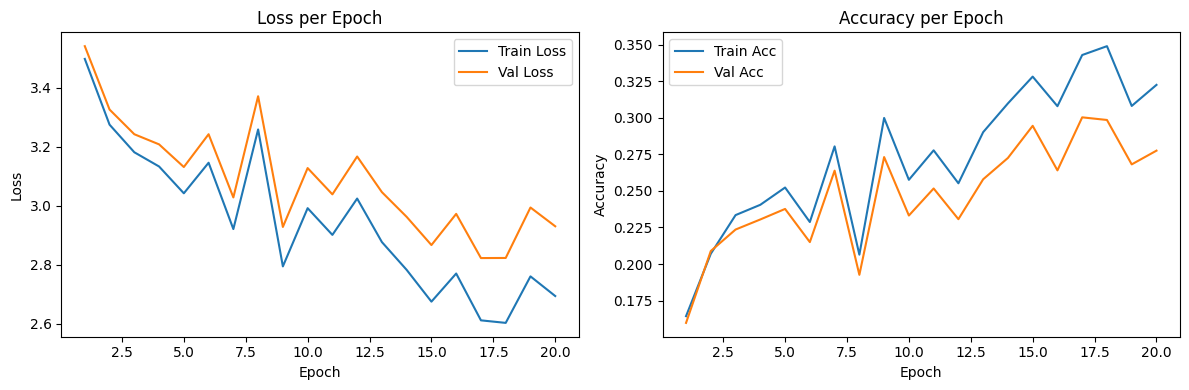

In [ ]:
plot_history(history)

## another hyberparameters of filter

In [ ]:
import torch
import torch.nn as nn

model2 = nn.Sequential(

    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=0),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(8 * 8 * 128, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(128, 100)
)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model2.to(device)

learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
history = fit(model= model, train_loader=trainloader, valid_loader = testloader, optimizer = optimizer, num_epochs= 20, verbose = False)


Epoch 1/20
train loss= 3.5399 - train acc= 16.26% - valid loss= 3.5776 - valid acc= 16.16%
Epoch 2/20
train loss= 3.2032 - train acc= 23.14% - valid loss= 3.2670 - valid acc= 22.25%
Epoch 3/20
train loss= 2.9498 - train acc= 28.16% - valid loss= 3.0429 - valid acc= 26.70%
Epoch 4/20
train loss= 2.7667 - train acc= 31.19% - valid loss= 2.8988 - valid acc= 28.83%
Epoch 5/20
train loss= 2.6901 - train acc= 33.85% - valid loss= 2.8402 - valid acc= 30.82%
Epoch 6/20
train loss= 2.5795 - train acc= 35.20% - valid loss= 2.7638 - valid acc= 31.09%
Epoch 7/20
train loss= 2.4800 - train acc= 37.88% - valid loss= 2.6978 - valid acc= 33.19%
Epoch 8/20
train loss= 2.3912 - train acc= 39.78% - valid loss= 2.6475 - valid acc= 33.42%
Epoch 9/20
train loss= 2.3540 - train acc= 40.65% - valid loss= 2.6340 - valid acc= 34.14%
Epoch 10/20
train loss= 2.2877 - train acc= 41.86% - valid loss= 2.5998 - valid acc= 34.41%
Epoch 11/20
train loss= 2.2034 - train acc= 43.59% - valid loss= 2.5572 - valid acc= 35.6

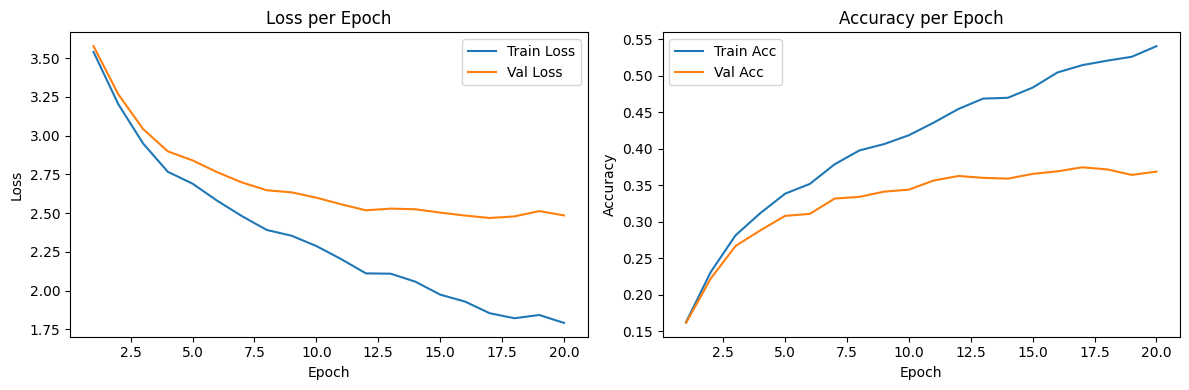

In [ ]:
plot_history(history)

## More layers

In [ ]:
import torch
import torch.nn as nn

model3 = nn.Sequential(

    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=7, stride=1, padding=0),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),


    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),


    nn.Flatten(),
    nn.Linear(6 * 6 * 128, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 100)
)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model3 = model3.to(device)

learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)

Epoch 1/20
train loss= 3.7664 - train acc= 12.27% - valid loss= 3.7916 - valid acc= 11.48%
Epoch 2/20
train loss= 3.3566 - train acc= 18.79% - valid loss= 3.4306 - valid acc= 17.86%
Epoch 3/20
train loss= 3.1506 - train acc= 22.89% - valid loss= 3.2794 - valid acc= 20.73%
Epoch 4/20
train loss= 2.8896 - train acc= 28.85% - valid loss= 3.0901 - valid acc= 25.00%
Epoch 5/20
train loss= 2.7343 - train acc= 31.04% - valid loss= 3.0173 - valid acc= 26.43%
Epoch 6/20
train loss= 2.5381 - train acc= 34.93% - valid loss= 2.9292 - valid acc= 28.01%
Epoch 7/20
train loss= 2.4291 - train acc= 37.01% - valid loss= 2.9438 - valid acc= 28.44%
Epoch 8/20
train loss= 2.2235 - train acc= 42.10% - valid loss= 2.8998 - valid acc= 29.61%
Epoch 9/20
train loss= 2.0714 - train acc= 45.68% - valid loss= 2.8889 - valid acc= 30.32%
Epoch 10/20
train loss= 1.9929 - train acc= 47.46% - valid loss= 2.9767 - valid acc= 29.67%
Epoch 11/20
train loss= 1.7733 - train acc= 52.77% - valid loss= 2.9882 - valid acc= 30.3

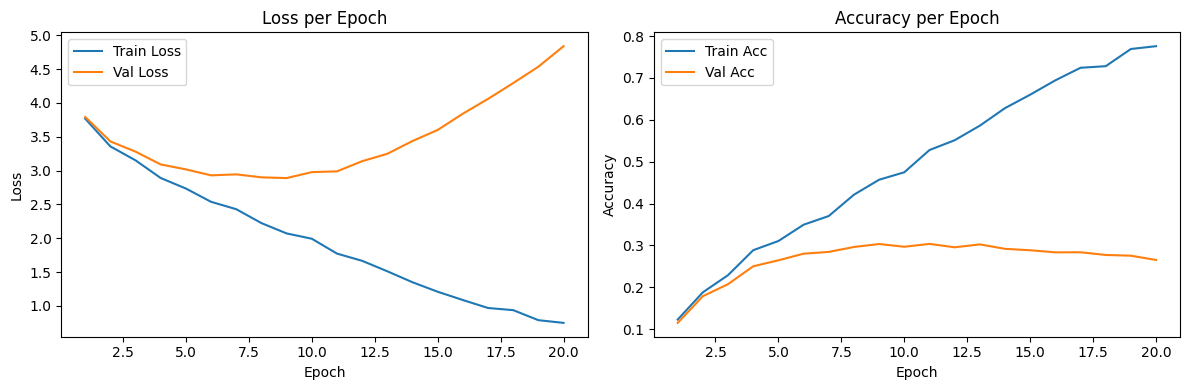

In [ ]:
history = fit(model= model3, train_loader=trainloader, valid_loader = testloader, optimizer = optimizer, num_epochs= 20, verbose = False)
plot_history(history)

## Using Residual Block

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity() # do nothing

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = F.relu(out)
        return out


class model4(nn.Module):

      def __init__ (self):
          super().__init__()
          self.conv1 = nn.Conv2d(3, 16, kernel_size=7, stride=1, padding=0)
          self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
          self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
          self.resblock = ResidualBlock(in_channels=32, out_channels=32, stride=1)
          self.fc1 = nn.Linear(6*6*32,128)
          self.fc2 = nn.Linear(128,100)




      def forward(self, x):
          x = F.relu(self.conv1(x))
          x = self.pool(x)
          x = F.relu(self.conv2(x))
          x = self.pool(x)
          x = self.resblock(x)
          x = x.view(-1, 6*6*32)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)

          return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model4 = model4().to(device)

learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=learning_rate)

Epoch 1/20
train loss= 3.5772 - train acc= 14.74% - valid loss= 3.6276 - valid acc= 14.19%
Epoch 2/20
train loss= 3.0104 - train acc= 25.51% - valid loss= 3.1252 - valid acc= 24.17%
Epoch 3/20
train loss= 2.9030 - train acc= 27.92% - valid loss= 3.0590 - valid acc= 25.10%
Epoch 4/20
train loss= 2.9441 - train acc= 27.32% - valid loss= 3.1348 - valid acc= 24.74%
Epoch 5/20
train loss= 2.5404 - train acc= 34.36% - valid loss= 2.8065 - valid acc= 29.65%
Epoch 6/20
train loss= 2.4450 - train acc= 36.79% - valid loss= 2.7638 - valid acc= 31.33%
Epoch 7/20
train loss= 2.4057 - train acc= 37.74% - valid loss= 2.7651 - valid acc= 31.13%
Epoch 8/20
train loss= 2.2978 - train acc= 40.25% - valid loss= 2.7362 - valid acc= 32.50%
Epoch 9/20
train loss= 2.1257 - train acc= 43.79% - valid loss= 2.6274 - valid acc= 34.60%
Epoch 10/20
train loss= 2.0627 - train acc= 44.75% - valid loss= 2.6281 - valid acc= 34.85%
Epoch 11/20
train loss= 1.9982 - train acc= 46.33% - valid loss= 2.6156 - valid acc= 34.9

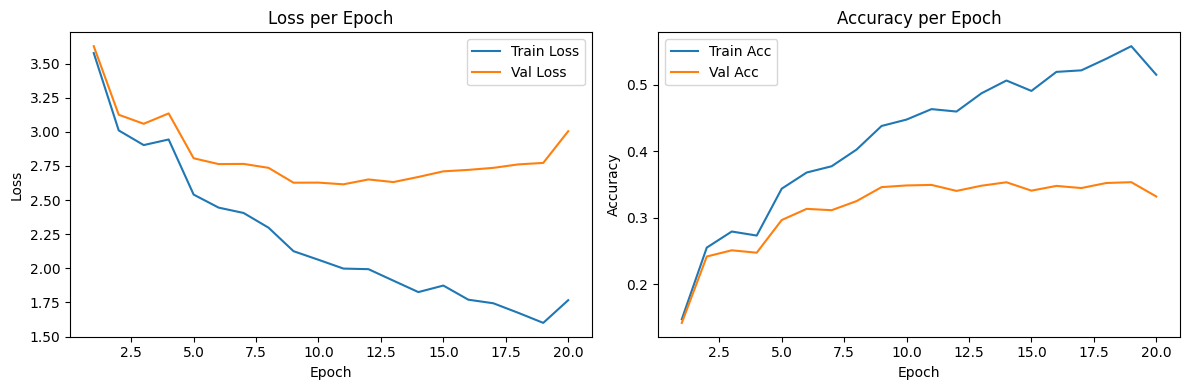

In [ ]:
history = fit(model= model4, train_loader=trainloader, valid_loader = testloader, optimizer = optimizer, num_epochs= 20, verbose = False)
plot_history(history)

## Using inception module

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels_per_branch):
        super().__init__()

        self.branch1 = nn.Conv2d(in_channels, out_channels_per_branch, kernel_size=7, stride=1, padding=0)         # Branch 2: 5x5 conv followed by 3x3 conv

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels_per_branch, kernel_size=5, stride=1, padding=0),
            nn.Conv2d(out_channels_per_branch, out_channels_per_branch, kernel_size=3, stride=1, padding=0)        # Branch 2: 5x5 conv followed by 3x3 conv
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels_per_branch, kernel_size=3, stride=1, padding=0),
            nn.Conv2d(out_channels_per_branch, out_channels_per_branch, kernel_size=5, stride=1, padding=0)        # Branch 3: 3x3 conv followed by 5x5 conv
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=7, stride=1, padding=0),
            nn.Conv2d(in_channels, out_channels_per_branch, kernel_size=1, stride=1, padding=0)                    # Branch 4: 7x7 max pooling followed by 1x1 conv
        )

    def forward(self, x):
        b1 = F.relu(self.branch1(x))
        b2 = F.relu(self.branch2(x))
        b3 = F.relu(self.branch3(x))
        b4 = F.relu(self.branch4(x))
        return torch.cat([b1, b2, b3, b4], dim=1)

class model5(nn.Module):
    def __init__(self):
        super().__init__()
        self.inception = InceptionModule(in_channels=3, out_channels_per_branch=4)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(6*6*32, 128)
        self.fc2 = nn.Linear(128, 100)

    def forward(self, x):
        x = self.inception(x)
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 6*6*32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model5 = model5().to(device)

learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model5.parameters(), lr=learning_rate)

Epoch 1/20
train loss= 3.5137 - train acc= 16.25% - valid loss= 3.5614 - valid acc= 15.80%
Epoch 2/20
train loss= 3.1816 - train acc= 22.09% - valid loss= 3.2608 - valid acc= 21.43%
Epoch 3/20
train loss= 2.9670 - train acc= 26.69% - valid loss= 3.0856 - valid acc= 24.57%
Epoch 4/20
train loss= 2.8097 - train acc= 30.12% - valid loss= 2.9758 - valid acc= 27.19%
Epoch 5/20
train loss= 2.6536 - train acc= 33.15% - valid loss= 2.8481 - valid acc= 29.59%
Epoch 6/20
train loss= 2.6001 - train acc= 34.06% - valid loss= 2.8473 - valid acc= 30.29%
Epoch 7/20
train loss= 2.5018 - train acc= 36.14% - valid loss= 2.7922 - valid acc= 31.11%
Epoch 8/20
train loss= 2.3822 - train acc= 38.60% - valid loss= 2.7165 - valid acc= 32.55%
Epoch 9/20
train loss= 2.3135 - train acc= 40.02% - valid loss= 2.6877 - valid acc= 33.09%
Epoch 10/20
train loss= 2.3005 - train acc= 40.48% - valid loss= 2.7069 - valid acc= 33.12%
Epoch 11/20
train loss= 2.2356 - train acc= 42.11% - valid loss= 2.6824 - valid acc= 33.6

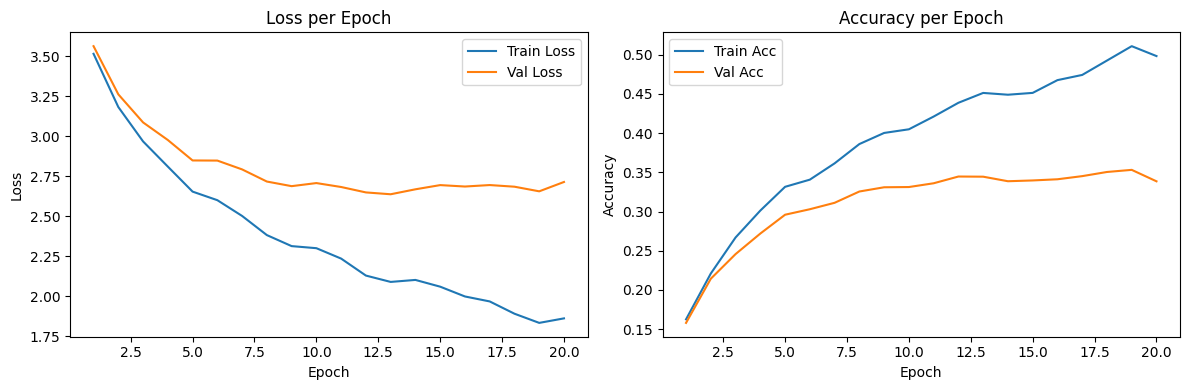

In [ ]:
history = fit(model= model5, train_loader=trainloader, valid_loader = testloader, optimizer = optimizer, num_epochs= 20, verbose = False)
plot_history(history)

#Task 3 - Find the best model (5 marks)

In [ ]:
def fit(model= None, train_loader = None, valid_loader= None, optimizer = None,patience=3,
        num_epochs = 50, verbose = True, seed= 1234):
  torch.manual_seed(seed)

  file_name = "model_ultra1.pth"

  model.to(device)
  optim = optimizer
  history = dict()

  history['val_loss'] = list()
  history['val_acc'] = list()
  history['train_loss'] = list()
  history['train_acc'] = list()

  for epoch in range(num_epochs):
    model.train()
    for (X, y) in train_loader:

      X,y = X.to(device), y.to(device)

      outputs = model(X.type(torch.float32))
      loss = loss_fn(outputs, y.type(torch.long))
      # Backward and optimize
      optim.zero_grad()
      loss.backward()
      optim.step()

    #losses and accuracies for epoch
    val_loss = compute_loss(model, loss_fn, valid_loader)
    val_acc = compute_acc(model, valid_loader)
    train_loss = compute_loss(model, loss_fn, train_loader)
    train_acc = compute_acc(model, train_loader)

    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    best_val_acc = 0

    if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            # save the best model so far
            torch.save(model.state_dict(), file_name)
            print(f"best accuracy so far is {best_val_acc}")
    else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                if verbose:
                    print(f"No improvement for {patience} epochs. "
                          f"Stopping at epoch {epoch+1}.")
                break

    if not verbose:
      print(f"Epoch {epoch+1}/{num_epochs}")
      print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")

  return history

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1x1 = nn.Conv2d(in_channels, out_channels//4, 1)
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels//4, 1),
            nn.Conv2d(out_channels//4, out_channels//4, 3, padding=1)
        )
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels//4, 1),
            nn.Conv2d(out_channels//4, out_channels//4, 5, padding=2)
        )
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_channels//4, 1)
        )

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)
        return torch.cat([branch1x1, branch3x3, branch5x5, branch_pool], 1)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = F.relu(out)
        return out

class model_ultra1(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.features = nn.Sequential(
            # Initial convolution layer
            nn.Conv2d(3, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),

            # First residual block
            ResidualBlock(96, 96, stride=1),

            # Inception module
            InceptionModule(96, 192),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),


            ResidualBlock(192, 192, stride=1),

            #   reducing the spatial resolution
            ResidualBlock(192, 384, stride=2),


            InceptionModule(384, 384),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),


            ResidualBlock(384, 384, stride=1),
            ResidualBlock(384, 384, stride=1),


            ResidualBlock(384, 768, stride=2),


            InceptionModule(768, 768),
            nn.BatchNorm2d(768),
            nn.ReLU(inplace=True),


            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(768, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ultra1 = model_ultra1().to(device)

learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ultra1.parameters(), lr=learning_rate)

In [ ]:
total = 0
for name, param in model_ultra1.named_parameters():
    if param.requires_grad:          # skip frozen layers if any
        n_param = param.numel()
        print(f"{name:30s}  shape={tuple(param.shape)!s:15}  n={n_param:>8,d}")
        total += n_param

print(f"\nTOTAL TRAINABLE PARAMETERS: {total:,}")

features.0.weight               shape=(96, 3, 3, 3)    n=   2,592
features.0.bias                 shape=(96,)            n=      96
features.1.weight               shape=(96,)            n=      96
features.1.bias                 shape=(96,)            n=      96
features.3.conv1.weight         shape=(96, 96, 3, 3)   n=  82,944
features.3.conv1.bias           shape=(96,)            n=      96
features.3.bn1.weight           shape=(96,)            n=      96
features.3.bn1.bias             shape=(96,)            n=      96
features.3.conv2.weight         shape=(96, 96, 3, 3)   n=  82,944
features.3.conv2.bias           shape=(96,)            n=      96
features.3.bn2.weight           shape=(96,)            n=      96
features.3.bn2.bias             shape=(96,)            n=      96
features.4.branch1x1.weight     shape=(48, 96, 1, 1)   n=   4,608
features.4.branch1x1.bias       shape=(48,)            n=      48
features.4.branch3x3.0.weight   shape=(48, 96, 1, 1)   n=   4,608
features.4

In [ ]:
history = fit(model= model_ultra1 , train_loader=trainloader_da, valid_loader = testloader, optimizer = optimizer, num_epochs= 30, verbose = False)

best accuracy so far is 0.0987
Epoch 1/30
train loss= 3.6999 - train acc= 10.86% - valid loss= 3.7438 - valid acc= 9.87%
best accuracy so far is 0.1459
Epoch 2/30
train loss= 3.4163 - train acc= 15.91% - valid loss= 3.4956 - valid acc= 14.59%
best accuracy so far is 0.2273
Epoch 3/30
train loss= 2.9689 - train acc= 24.14% - valid loss= 2.9720 - valid acc= 22.73%
best accuracy so far is 0.2744
Epoch 4/30
train loss= 2.7546 - train acc= 27.29% - valid loss= 2.7508 - valid acc= 27.44%
best accuracy so far is 0.3171
Epoch 5/30
train loss= 2.5120 - train acc= 32.75% - valid loss= 2.5268 - valid acc= 31.71%
best accuracy so far is 0.3733
Epoch 6/30
train loss= 2.2975 - train acc= 37.83% - valid loss= 2.3165 - valid acc= 37.33%
best accuracy so far is 0.4329
Epoch 7/30
train loss= 2.0770 - train acc= 42.92% - valid loss= 2.0734 - valid acc= 43.29%
best accuracy so far is 0.4413
Epoch 8/30
train loss= 2.0165 - train acc= 44.34% - valid loss= 2.0449 - valid acc= 44.13%
best accuracy so far is 0

In [ ]:
model_ultra1.load_state_dict(torch.load("model_ultra1.pth"))

<All keys matched successfully>

In [ ]:
model_ultra1.eval()
test_loss = compute_loss(model_ultra1, loss_fn, testloader)
test_acc  = compute_acc( model_ultra1, testloader)
print(f" - valid loss= {test_loss:.4f} - valid acc= {test_acc*100:.2f}%")

 - valid loss= 1.2851 - valid acc= 66.13%


## load the checkpoint file and evaluating ( no need for training , only execute the model architecture , dataset and model parameter )

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1TvmpZwGp0XofNQZL1QEE6RnX0g1Tpuy3/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1TvmpZwGp0XofNQZL1QEE6RnX0g1Tpuy3
From (redirected): https://drive.google.com/uc?id=1TvmpZwGp0XofNQZL1QEE6RnX0g1Tpuy3&confirm=t&uuid=b62f57fd-ab9e-4588-8864-509e701d5c68
To: /content/model_ultra1.pth
100% 77.9M/77.9M [00:00<00:00, 170MB/s]


In [ ]:
model_eval1 = model_ultra1().to(device)
ckpt = torch.load("model_ultra1.pth", map_location=device)
model_eval1.load_state_dict(ckpt)
test_loss = compute_loss(model_eval1, loss_fn, testloader)
test_acc  = compute_acc(model_eval1, testloader) * 100
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Test Loss: 1.2030
Test Accuracy: 68.52%


#Task 4 - Explore image classification (4 marks)

In [ ]:
def fit(model= None, train_loader = None, valid_loader= None, optimizer = None,patience=3,
        num_epochs = 50, verbose = True, seed= 1234):
  torch.manual_seed(seed)

  file_name = "model_ultra1_init.pth"

  model.to(device)
  optim = optimizer
  history = dict()

  history['val_loss'] = list()
  history['val_acc'] = list()
  history['train_loss'] = list()
  history['train_acc'] = list()

  for epoch in range(num_epochs):
    model.train()
    for (X, y) in train_loader:

      X,y = X.to(device), y.to(device)

      outputs = model(X.type(torch.float32))
      loss = loss_fn(outputs, y.type(torch.long))
      # Backward and optimize
      optim.zero_grad()
      loss.backward()
      optim.step()

    #losses and accuracies for epoch
    val_loss = compute_loss(model, loss_fn, valid_loader)
    val_acc = compute_acc(model, valid_loader)
    train_loss = compute_loss(model, loss_fn, train_loader)
    train_acc = compute_acc(model, train_loader)

    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    best_val_acc = 0

    if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            # save the best model so far
            torch.save(model.state_dict(), file_name)
            print(f"best accuracy so far is {best_val_acc}")
    else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                if verbose:
                    print(f"No improvement for {patience} epochs. "
                          f"Stopping at epoch {epoch+1}.")
                break

    if not verbose:
      print(f"Epoch {epoch+1}/{num_epochs}")
      print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")

  return history

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1x1 = nn.Conv2d(in_channels, out_channels//4, 1)
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels//4, 1),
            nn.Conv2d(out_channels//4, out_channels//4, 3, padding=1)
        )
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels//4, 1),
            nn.Conv2d(out_channels//4, out_channels//4, 5, padding=2)
        )
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_channels//4, 1)
        )

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)
        return torch.cat([branch1x1, branch3x3, branch5x5, branch_pool], 1)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = F.relu(out)
        return out

class model_ultra1_init(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.features = nn.Sequential(
            # Initial convolution layer with more filters
            nn.Conv2d(3, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),

            # First residual block with more filters
            ResidualBlock(96, 96, stride=1),

            # Inception module
            InceptionModule(96, 192),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),


            ResidualBlock(192, 192, stride=1),


            ResidualBlock(192, 384, stride=2),


            InceptionModule(384, 384),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),


            ResidualBlock(384, 384, stride=1),
            ResidualBlock(384, 384, stride=1),


            ResidualBlock(384, 768, stride=2),


            InceptionModule(768, 768),
            nn.BatchNorm2d(768),
            nn.ReLU(inplace=True),


            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(768, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        self.apply(self._initialize_weights_fn)

    def _initialize_weights_fn(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):

            if m == self.classifier[-1]:
                nn.init.xavier_normal_(m.weight)  # Xavier for the output layer
            else: # He for other linear layers (presumably followed by ReLU)
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ultra1_init = model_ultra1_init().to(device)

learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ultra1_init.parameters(), lr=learning_rate)

In [ ]:
history = fit(model= model_ultra1_init , train_loader=trainloader_da, valid_loader = testloader, optimizer = optimizer, num_epochs= 30, verbose = False)

best accuracy so far is 0.1084
Epoch 1/30
train loss= 3.7437 - train acc= 10.89% - valid loss= 3.7601 - valid acc= 10.84%
best accuracy so far is 0.16
Epoch 2/30
train loss= 3.4677 - train acc= 15.47% - valid loss= 3.4121 - valid acc= 16.00%
best accuracy so far is 0.212
Epoch 3/30
train loss= 3.0883 - train acc= 22.27% - valid loss= 3.1177 - valid acc= 21.20%
best accuracy so far is 0.3206
Epoch 4/30
train loss= 2.6136 - train acc= 31.32% - valid loss= 2.5836 - valid acc= 32.06%
best accuracy so far is 0.3355
Epoch 5/30
train loss= 2.5104 - train acc= 33.18% - valid loss= 2.5042 - valid acc= 33.55%
best accuracy so far is 0.3797
Epoch 6/30
train loss= 2.2793 - train acc= 38.28% - valid loss= 2.2941 - valid acc= 37.97%
best accuracy so far is 0.4413
Epoch 7/30
train loss= 1.9842 - train acc= 45.29% - valid loss= 2.0385 - valid acc= 44.13%
best accuracy so far is 0.4741
Epoch 8/30
train loss= 1.8536 - train acc= 48.50% - valid loss= 1.8583 - valid acc= 47.41%
best accuracy so far is 0.4

## load the checkpoint file and evaluating ( no need for training , only execute the model architecture , dataset and model parameter )

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1VKiDa95OccRRU88uWFBuumXShs_yD3qB/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1VKiDa95OccRRU88uWFBuumXShs_yD3qB
From (redirected): https://drive.google.com/uc?id=1VKiDa95OccRRU88uWFBuumXShs_yD3qB&confirm=t&uuid=a7cb2639-fe51-4dd7-b565-e8b83eb882f8
To: /content/model_ultra1_init.pth
100% 77.9M/77.9M [00:00<00:00, 188MB/s]


In [ ]:
model_eval2 = model_ultra1_init().to(device)
ckpt = torch.load("model_ultra1_init.pth", map_location=device)
model_eval2.load_state_dict(ckpt)
test_loss = compute_loss(model_eval2, loss_fn, testloader)
test_acc  = compute_acc(model_eval2, testloader) * 100
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Test Loss: 1.1938
Test Accuracy: 68.71%
